In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import time
import sys

import tensorflow as tf
import matplotlib. pyplot as plt
from tensorflow.python.keras import layers
from tensorflow import keras
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Flatten, Dense, Dropout
from tensorflow.python.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator





In [3]:
print ("Current working dir : " + os.getcwd())


Current working dir : /sfs/qumulo/qhome/cbh2ta/Documents/dplearn


In [4]:
train_dir = '/sfs/qumulo/qhome/cbh2ta/Documents/dplearn/chest_xray/chest_xray/train'

test_dir = '/sfs/qumulo/qhome/cbh2ta/Documents/dplearn/chest_xray/chest_xray/test'

# train_dir = '/sfs/qumulo/qhome/ss9ud/Documents/deeplearningFINAL/chest_xray/chest_xray/train'
# test_dir = '/sfs/qumulo/qhome/ss9ud/Documents/deeplearningFINAL/chest_xray/chest_xray/test'

#train_dir = '/Users/mariahhurt/Desktop/chest_xray/train'
#test_dir = '/Users/mariahhurt/Desktop/chest_xray/test'

In [28]:
# hyper parameters for model
#DATASET_PATH = '/Users/mariahhurt/Desktop/chest_xray'
DATASET_PATH = '/sfs/qumulo/qhome/cbh2ta/Documents/dplearn/chest_xray/chest_xray'

NUM_CLASSES = 2  # number of classes
based_model_last_block_layer_number = 126  # value is based on based model selected
img_width, img_height = 299, 299  # change based on the shape/structure of images
batch_size = 32  # try 4, 8, 16, 32, 64, 128, 256 usually dependent on CPU/GPU memory capacity (powers of 2 values).
nb_epoch = 10  # number of iteration the algorithm gets trained
learn_rate = 1e-6  # sgd learning rate
momentum = .9  # sgd momentum to avoid local minimum
transformation_ratio = .05  # how aggressive will be the data augmentation/transformation

In [29]:
 #train_datagen = ImageDataGenerator(rescale=1. / 255,
                                       #rotation_range=transformation_ratio,
                                       #shear_range=transformation_ratio,
                                       #zoom_range=transformation_ratio,
                                       #cval=0,
                                       #horizontal_flip=True,
                                       #vertical_flip=False)
    
    
    # try these new data augmentation code 
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                       rotation_range=3,
                                        width_shift_range=transformation_ratio,
                                       shear_range=transformation_ratio,
                                       zoom_range=transformation_ratio,
                                        fill_mode = 'constant',
                                       cval=0,
                                       horizontal_flip=True,
                                       vertical_flip=True)


validation_datagen = ImageDataGenerator(rescale=1. / 255)

   
    
train_generator = train_datagen.flow_from_directory(DATASET_PATH + '/train',
                                                        target_size=(img_width, img_height),
                                                        batch_size=batch_size,
                                                        class_mode='binary')


validation_generator = validation_datagen.flow_from_directory(DATASET_PATH + '/test',
                                                                  target_size=(img_width, img_height),
                                                                  batch_size=batch_size,
                                                                    class_mode='binary')


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [30]:
# show class indices
print('****************')
for cls, idx in train_generator.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))
print('****************')

****************
Class #0 = NORMAL
Class #1 = PNEUMONIA
****************


In [31]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer

In [32]:
# load pre-trained InceptionV3 model 
# InceptionV3 has been trained on the ImageNet data
original_model    = InceptionV3()
bottleneck_input  = original_model.get_layer(index=0).input
bottleneck_output = original_model.get_layer(index=-2).output
bottleneck_model  = Model(inputs=bottleneck_input,outputs=bottleneck_output)
# we instantiate a new model with the original image input and
#the bottleneck layer as output: Model(inputs=bottleneck_input, outputs=bottleneck_output).

# we load the pretrained model  - InceptionV3
# extracted the input from the last and second to last bottle neck layer from the original model using TensorFlow’s .get_layer() 
# we then builded a new model using those two layers as input and output

In [33]:
for layer in bottleneck_model.layers:
    layer.trainable = False
    
#freezing the weights and biases of these layers
# retaining the information

In [34]:
print(bottleneck_model.get_layer(index=7).input)
# sanity check

Tensor("activation_95/Identity:0", shape=(None, 147, 147, 32), dtype=float32)


In [35]:
# print(bottleneck_model.summary())

In [36]:
#  we made a new Sequential() model, starting with our previous building block 
new_model = Sequential()
new_model.add(bottleneck_model)
#print(new_model.get_input_at(0))
#new_model.add(Dense(2, activation='softmax', input_dim=2048))
new_model.add(layers.Flatten())

new_model.add(layers.Dropout(.35, noise_shape=None, seed=None))
# new_model.add(layers.Dense(512, activation='relu'))

new_model.add(layers.Dense(1, activation='sigmoid',input_dim=2048))

# we used a composite model which combines our Inception architecture with a final 
# layer using the sigmoid because this is a binary classificaiton

In [37]:
print(new_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 2048)              21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________
None


In [38]:
#new_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-5),
                 # loss='binary_crossentropy', metrics=['accuracy'])

new_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learn_rate),
                  loss='binary_crossentropy', metrics=['accuracy'])


In [39]:
history = new_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples//train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator, validation_steps=validation_generator.samples//validation_generator.batch_size,
    verbose=1)


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 163 steps, validate for 19 steps
Epoch 1/10
163/163 [==============================] - 322s 2s/step - loss: 0.7765 - accuracy: 0.4172 - val_loss: 0.7681 - val_accuracy: 0.3750
Epoch 2/10
163/163 [==============================] - 323s 2s/step - loss: 0.7554 - accuracy: 0.4444 - val_loss: 0.7507 - val_accuracy: 0.4013
Epoch 3/10
163/163 [==============================] - 319s 2s/step - loss: 0.7291 - accuracy: 0.4939 - val_loss: 0.7363 - val_accuracy: 0.4490
Epoch 4/10
163/163 [==============================] - 330s 2s/step - loss: 0.7092 - accuracy: 0.5203 - val_loss: 0.7248 - val_accuracy: 0.4901
Epoch 5/10
163/163 [==============================] - 317s 2s/step - loss: 0.6878 - accuracy: 0.5621 - val_loss: 0.7162 - val_accuracy: 0.5378
Epoch 6/10
163/163 [==============================] - 318s 2s/step - loss: 0.6681 - accuracy: 0.5880 - val_loss: 0.7101 - val_accuracy: 0.5625
Epoch 7/10
163/163 [==============================] - 313s 2s/step - loss: 0.6566 - accuracy: 0.620

In [40]:
history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(history.history['accuracy']) + 1)

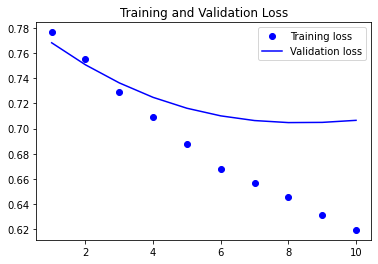

In [41]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

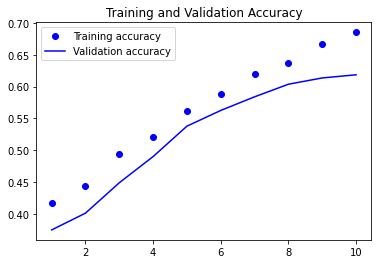

In [42]:
plt.plot(epochs, history.history['accuracy'], 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()